# Double Machine Learning Simplified 

## Part 2: Extensions & the CATE

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from stargazer.stargazer import Stargazer  # noqa: F401
import matplotlib.pyplot as plt

In [2]:
COLORS = ["#00B0F0", "#FF0000", "#B0F000"]


def plot_effect(effect_true, effect_pred, figsize=(8, 5), ylim=(-10, 100)):
    plt.figure(figsize=figsize)  # , dpi=250)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(
        np.sort(effect_true),
        np.sort(effect_true),
        color=COLORS[1],
        alpha=0.7,
        label="Perfect model",
    )
    plt.xlabel("$True\ effect$", fontsize=14)
    plt.ylabel("$Predicted\ effect$", fontsize=14)
    # plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

### Linear DML

In [3]:
N = 100_000

# Confounders
age = np.random.randint(low=18, high=75, size=N)
num_social_media_profiles = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], size=N)
yr_membership = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], size=N)

# Covariates
X = np.random.normal(loc=50, scale=25, size=N)

# Error Terms
ε1 = np.random.normal(loc=20, scale=5, size=N)
ε2 = np.random.normal(loc=40, scale=15, size=N)

# Treatment (T)
time_on_website = np.maximum(
    np.random.normal(loc=10, scale=5, size=N)
    - 0.01 * age
    - 0.001 * age**2
    + num_social_media_profiles
    - 0.01 * num_social_media_profiles**2
    - 0.01 * (age * num_social_media_profiles)
    + 0.2 * yr_membership
    + 0.001 * yr_membership**2
    - 0.01 * (age * yr_membership)
    + 0.2 * (num_social_media_profiles * yr_membership)
    + 0.01 * (num_social_media_profiles * np.log(age) * age * yr_membership ** (1 / 2))
    + ε1,
    0,
)

# Outcome (y)
sales = np.maximum(
    np.random.normal(loc=25, scale=10, size=N)
    + 5 * time_on_website  # Simulated ATE = 5
    - 0.2 * time_on_website * age
    + 2 * time_on_website * num_social_media_profiles
    + 2 * time_on_website * yr_membership
    - 0.1 * age
    - 0.001 * age**2
    + 8 * num_social_media_profiles
    - 0.1 * num_social_media_profiles**2
    - 0.01 * (age * num_social_media_profiles)
    + 2 * yr_membership
    + 0.1 * yr_membership**2
    - 0.01 * (age * yr_membership)
    + 3 * (num_social_media_profiles * yr_membership)
    + 0.1 * (num_social_media_profiles * np.log(age) * age * yr_membership ** (1 / 2))
    + 0.5 * X
    + ε2,
    0,
)

df = pd.DataFrame(
    np.array(
        [sales, time_on_website, age, num_social_media_profiles, yr_membership, X]
    ).T,
    columns=[
        "sales",
        "time_on_website",
        "age",
        "num_social_media_profiles",
        "yr_membership",
        "X",
    ],
)

In [4]:
# DML Procedure
M_sales = GradientBoostingRegressor()
M_time_on_website = GradientBoostingRegressor()

pred_sales = cross_val_predict(
    M_sales,
    df[["age", "num_social_media_profiles", "yr_membership"]],
    df["sales"],
    cv=3,
)
residualized_sales = df["sales"] - cross_val_predict(
    M_sales,
    df[["age", "num_social_media_profiles", "yr_membership"]],
    df["sales"],
    cv=3,
)
residualized_time_on_website = df["time_on_website"] - cross_val_predict(
    M_time_on_website,
    df[["age", "num_social_media_profiles", "yr_membership"]],
    df["time_on_website"],
    cv=3,
)

df["pred_sales"] = pred_sales
df["residualized_sales"] = residualized_sales
df["residualized_time_on_website"] = residualized_time_on_website

In [5]:
# DML Procedure
M_sales = GradientBoostingRegressor()
M_time_on_website = GradientBoostingRegressor()

residualized_sales = df["sales"] - cross_val_predict(
    M_sales,
    df[["age", "num_social_media_profiles", "yr_membership"]],
    df["sales"],
    cv=3,
)
residualized_time_on_website = df["time_on_website"] - cross_val_predict(
    M_time_on_website,
    df[["age", "num_social_media_profiles", "yr_membership"]],
    df["time_on_website"],
    cv=3,
)

df["residualized_sales"] = residualized_sales
df["residualized_time_on_website"] = residualized_time_on_website

DML_model = smf.ols(
    formula="residualized_sales ~ 1 + residualized_time_on_website + residualized_time_on_website:age + residualized_time_on_website:num_social_media_profiles + residualized_time_on_website:yr_membership",
    data=df,
).fit()
print(DML_model.summary())

                            OLS Regression Results                            
Dep. Variable:     residualized_sales   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 1.504e+05
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:04:20   Log-Likelihood:            -5.3932e+05
No. Observations:              100000   AIC:                         1.079e+06
Df Residuals:                   99995   BIC:                         1.079e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [6]:
# Predict CATE of 1 hour increase
df_predictions = df[
    [
        "residualized_time_on_website",
        "age",
        "num_social_media_profiles",
        "yr_membership",
    ]
].copy()
df_predictions["linear_DML_CATE"] = DML_model.predict(
    df_predictions.assign(
        residualized_time_on_website=lambda x: x.residualized_time_on_website + 1
    )
) - DML_model.predict(df_predictions)

# True CATE of 1 hour increase
df_predictions["true_CATE"] = (
    5
    - 0.2 * df_predictions["age"]
    + 2 * df_predictions["num_social_media_profiles"]
    + 2 * df_predictions["yr_membership"]
)

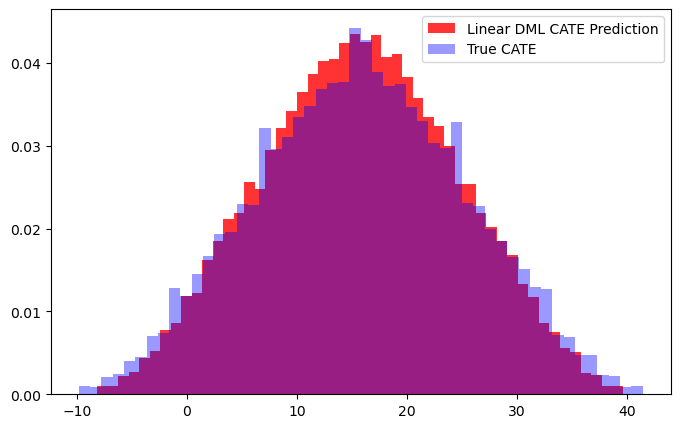

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))  # ,dpi=250)

ax.hist(
    df_predictions["linear_DML_CATE"],
    color="r",
    alpha=0.8,
    density=True,
    bins=50,
    label="Linear DML CATE Prediction",
)
ax.hist(
    df_predictions["true_CATE"],
    color="b",
    alpha=0.4,
    density=True,
    bins=50,
    label="True CATE",
)

ax.legend()
plt.show()

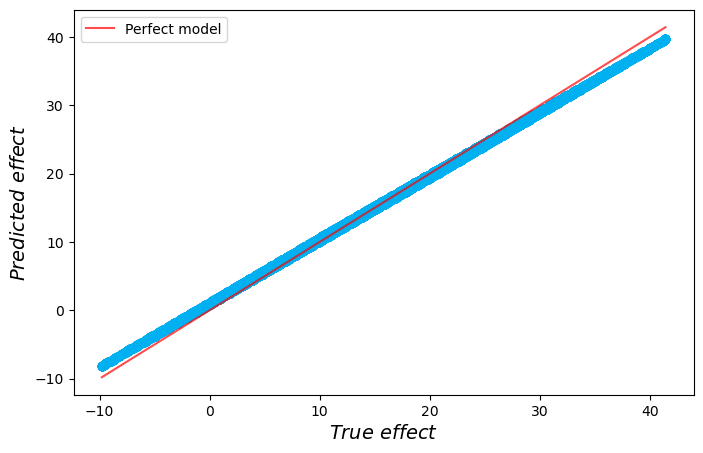

In [8]:
plot_effect(
    np.array(df_predictions["true_CATE"]), np.array(df_predictions["linear_DML_CATE"])
)

In [9]:
print(
    f"MSE: {mean_squared_error(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}"
)
print(f"R2: {r2_score(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")
print(
    f"MAE: {mean_absolute_error(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}"
)

MSE: 0.4095260361233053
R2: 0.9954608899642317
MAE: 0.5225196847156425


### Linear DML w/ Non-Linear CATE Function

In [10]:
N = 100_000

# Confounders
age = np.random.randint(low=18, high=75, size=N)
num_social_media_profiles = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], size=N)
yr_membership = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], size=N)

# Covariates
X = np.random.normal(loc=50, scale=25, size=N)

# Error Terms
ε1 = np.random.normal(loc=20, scale=5, size=N)
ε2 = np.random.normal(loc=40, scale=15, size=N)

# Treatment (T)
time_on_website = np.maximum(
    np.random.normal(loc=10, scale=5, size=N)
    - 0.01 * age
    - 0.001 * age**2
    + num_social_media_profiles
    - 0.01 * num_social_media_profiles**2
    - 0.01 * (age * num_social_media_profiles)
    + 0.2 * yr_membership
    + 0.001 * yr_membership**2
    - 0.01 * (age * yr_membership)
    + 0.2 * (num_social_media_profiles * yr_membership)
    + 0.01 * (num_social_media_profiles * np.log(age) * age * yr_membership ** (1 / 2))
    + ε1,
    0,
)

# Outcome (y)
sales = np.maximum(
    np.random.normal(loc=25, scale=10, size=N)
    + 5 * time_on_website  # Simulated ATE = 5
    - 0.2 * time_on_website * age
    - 0.0005 * time_on_website * age**2
    + 0.8 * time_on_website * num_social_media_profiles
    + 0.001 * time_on_website * num_social_media_profiles**2
    + 0.8 * time_on_website * yr_membership
    + 0.001 * time_on_website * yr_membership**2
    + 0.005 * time_on_website * yr_membership * num_social_media_profiles * age
    + 0.005
    * time_on_website
    * (yr_membership**3 / (1 + num_social_media_profiles**2))
    * np.log(age) ** 2
    - 0.1 * age
    - 0.001 * age**2
    + 8 * num_social_media_profiles
    - 0.1 * num_social_media_profiles**2
    - 0.01 * (age * num_social_media_profiles)
    + 2 * yr_membership
    + 0.1 * yr_membership**2
    - 0.01 * (age * yr_membership)
    + 3 * (num_social_media_profiles * yr_membership)
    + 0.1 * (num_social_media_profiles * np.log(age) * age * yr_membership ** (1 / 2))
    + 0.5 * X
    + ε2,
    0,
)

df = pd.DataFrame(
    np.array(
        [sales, time_on_website, age, num_social_media_profiles, yr_membership, X]
    ).T,
    columns=[
        "sales",
        "time_on_website",
        "age",
        "num_social_media_profiles",
        "yr_membership",
        "X",
    ],
)

In [11]:
# DML Procedure
M_sales = GradientBoostingRegressor()
M_time_on_website = GradientBoostingRegressor()

residualized_sales = df["sales"] - cross_val_predict(
    M_sales,
    df[["age", "num_social_media_profiles", "yr_membership"]],
    df["sales"],
    cv=3,
)
residualized_time_on_website = df["time_on_website"] - cross_val_predict(
    M_time_on_website,
    df[["age", "num_social_media_profiles", "yr_membership"]],
    df["time_on_website"],
    cv=3,
)

df["residualized_sales"] = residualized_sales
df["residualized_time_on_website"] = residualized_time_on_website

DML_model = smf.ols(
    formula="residualized_sales ~ 1 + residualized_time_on_website + residualized_time_on_website:age + residualized_time_on_website:num_social_media_profiles + residualized_time_on_website:yr_membership",
    data=df,
).fit()
print(DML_model.summary())

                            OLS Regression Results                            
Dep. Variable:     residualized_sales   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                 4.107e+04
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:04:29   Log-Likelihood:            -5.8849e+05
No. Observations:              100000   AIC:                         1.177e+06
Df Residuals:                   99995   BIC:                         1.177e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [12]:
# Predict CATE of 1 hour increase
df_predictions = df[
    [
        "residualized_time_on_website",
        "age",
        "num_social_media_profiles",
        "yr_membership",
    ]
].copy()
df_predictions["linear_DML_CATE"] = DML_model.predict(
    df_predictions.assign(
        residualized_time_on_website=lambda x: x.residualized_time_on_website + 1
    )
) - DML_model.predict(df_predictions)

# True CATE of 1 hour increase
df_predictions["true_CATE"] = (
    5
    - 0.2 * df_predictions["age"]
    - 0.0005 * df_predictions["age"] ** 2
    + 0.8 * df_predictions["num_social_media_profiles"]
    + 0.001 * df_predictions["num_social_media_profiles"] ** 2
    + 0.8 * df_predictions["yr_membership"]
    + 0.001 * df_predictions["yr_membership"] ** 2
    + 0.005
    * df_predictions["yr_membership"]
    * df_predictions["num_social_media_profiles"]
    * df_predictions["age"]
    + +0.005
    * (
        df_predictions["yr_membership"] ** 3
        / (1 + df_predictions["num_social_media_profiles"] ** 2)
    )
    * np.log(df_predictions["age"]) ** 2
)

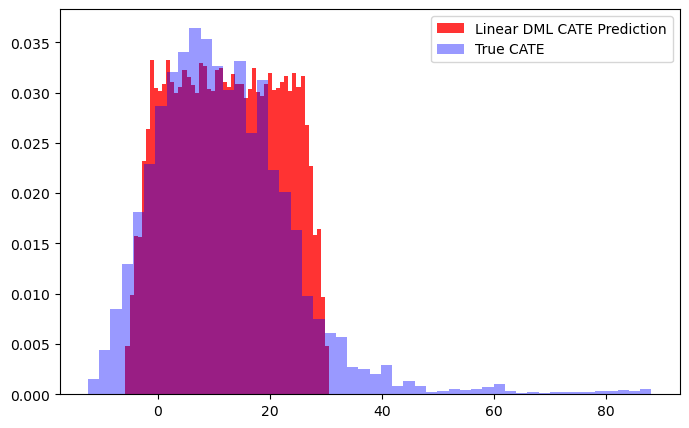

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))  # ,dpi=250)

ax.hist(
    df_predictions["linear_DML_CATE"],
    color="r",
    alpha=0.8,
    density=True,
    bins=50,
    label="Linear DML CATE Prediction",
)
ax.hist(
    df_predictions["true_CATE"],
    color="b",
    density=True,
    alpha=0.4,
    bins=50,
    label="True CATE",
)

ax.legend()
plt.show()

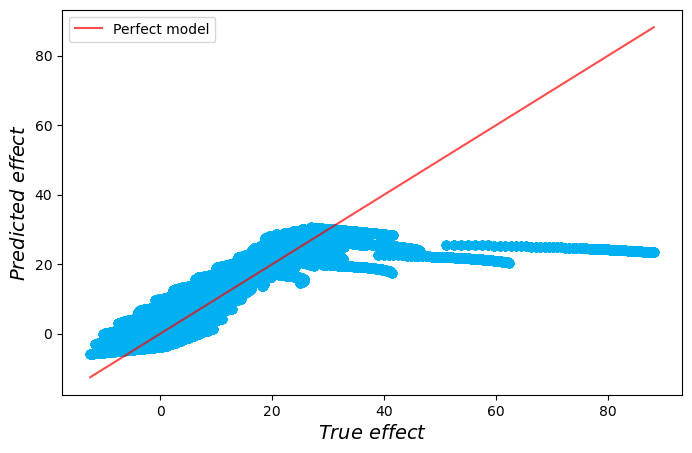

In [14]:
plot_effect(
    np.array(df_predictions["true_CATE"]), np.array(df_predictions["linear_DML_CATE"])
)

In [15]:
print(
    f"MSE: {mean_squared_error(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}"
)
print(f"R2: {r2_score(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")
print(
    f"MAE: {mean_absolute_error(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}"
)

MSE: 55.14984659588493
R2: 0.6529575101034173
MAE: 4.5245235937426935


### Non-Parametric DML

In [16]:
df["target"] = df["residualized_sales"] / df["residualized_time_on_website"]
df["weights"] = df["residualized_time_on_website"] ** 2

In [17]:
CATE_model = GradientBoostingRegressor()
CATE_model.fit(
    df[["age", "num_social_media_profiles", "yr_membership"]],
    df["target"],
    sample_weight=df["weights"],
)

df_predictions["Non_Parametric_DML_CATE"] = CATE_model.predict(
    df[["age", "num_social_media_profiles", "yr_membership"]]
)

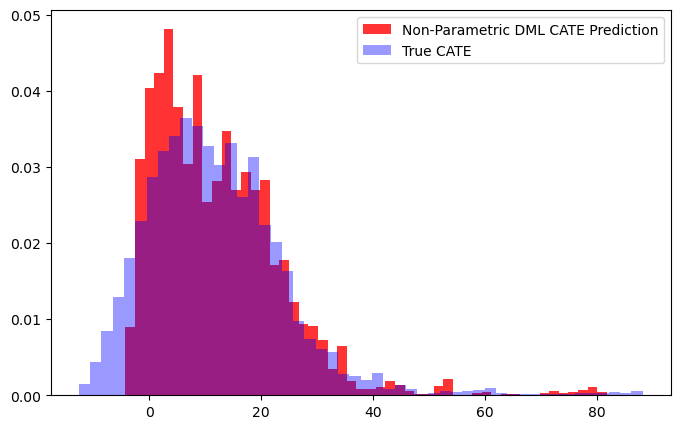

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))  # ,dpi=250)

ax.hist(
    df_predictions["Non_Parametric_DML_CATE"],
    color="r",
    alpha=0.8,
    density=True,
    bins=50,
    label="Non-Parametric DML CATE Prediction",
)
ax.hist(
    df_predictions["true_CATE"],
    color="b",
    density=True,
    alpha=0.4,
    bins=50,
    label="True CATE",
)

ax.legend()
plt.show()

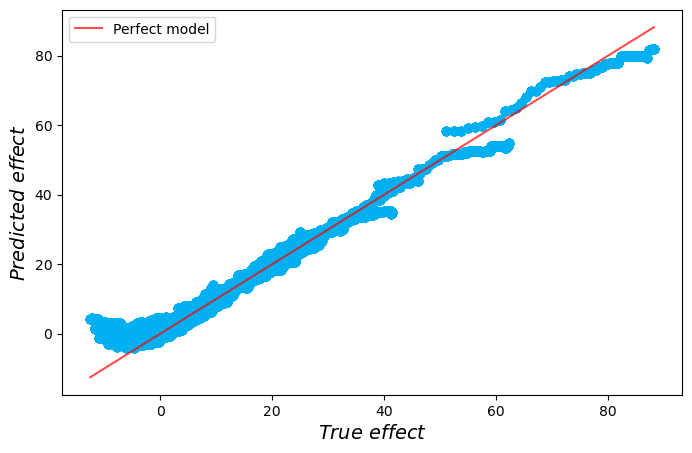

In [19]:
plot_effect(
    np.array(df_predictions["true_CATE"]),
    np.array(df_predictions["Non_Parametric_DML_CATE"]),
)

In [20]:
print(
    f"MSE: {mean_squared_error(df_predictions['true_CATE'], df_predictions['Non_Parametric_DML_CATE'])}"
)
print(
    f"R2: {r2_score(df_predictions['true_CATE'], df_predictions['Non_Parametric_DML_CATE'])}"
)
print(
    f"MAE: {mean_absolute_error(df_predictions['true_CATE'], df_predictions['Non_Parametric_DML_CATE'])}"
)

MSE: 4.786096556841653
R2: 0.9698824390547675
MAE: 1.3700941601842354
